![oi](ceb.png)

# Detecção de tumores cerebrais usando rede neural convolucional

## Nesse notebook vamos desenvolver um modelo de  machine learning capaz de identificar de tumores cerebrais em imagens de tomografia computadorizada. Para executar essa tarefa iremos construir uma rede neural convolucional. Uma rede neural convulacional (CNN na sigla inglesa) é uma rede neural expicializada em identificar corretamente imagens. Podemos entender os conceitos fundamentais das redes neurais convolucionais no excelente artigo: [Understanding ConvNets (CNN)](https://medium.com/neuronio/understanding-convnets-cnn-712f2afe4dd3).

![oi](convulução.gif)

## Os dados que usaremos para alimentar o modelo são dois conjuntos de dados: Um diretório de imagens de tomografia de secções de cérebros saudáveis e de secções de cérebros contendo tumores. Um dataset .csv contendo várias colunas com características associadas ao exame de tomografia. Além disso, nesse mesmo dataset temos uma coluna com a informação da classificação da imagem: A classe 1 representa presença de tumor e a classe 0 representa sem tumor. Então, atribuiremos as classes deste dataset com as imagens do diretório. Feito isso teremos os dados corretamnete identificáveis pela rede convolucional.

In [22]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from keras.layers import InputLayer, MaxPooling2D, Flatten, Dense, Conv2D, Dropout
from keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from PIL.Image import open

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
%matplotlib inline

In [8]:
# Criando o caminho do diretório das imagens
IMAGE_DATASET = "C:\\Users\\rondi\\Documents\\BrainTumorDetection\\Brain_Tumor"

# Definindo as dimensões das imagens inseridas na rede convolucional.
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Número de épocas dos dados de treino 
EPOCHS = 50

In [2]:
# Vamos importar o arquivo csv contendo as features e as classes das imagens
cortex_df = pd.read_csv("Brain Tumor.csv")
cortex_df.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


In [29]:
# Exibindo as informações gerais do dataset
cortex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Image               3762 non-null   object 
 1   Class               3762 non-null   int64  
 2   Mean                3762 non-null   float64
 3   Variance            3762 non-null   float64
 4   Standard Deviation  3762 non-null   float64
 5   Entropy             3762 non-null   float64
 6   Skewness            3762 non-null   float64
 7   Kurtosis            3762 non-null   float64
 8   Contrast            3762 non-null   float64
 9   Energy              3762 non-null   float64
 10  ASM                 3762 non-null   float64
 11  Homogeneity         3762 non-null   float64
 12  Dissimilarity       3762 non-null   float64
 13  Correlation         3762 non-null   float64
 14  Coarseness          3762 non-null   float64
dtypes: float64(13), int64(1), object(1)
memory usage: 441.0

## Vemos que não há dados ausemtes nas colunas.

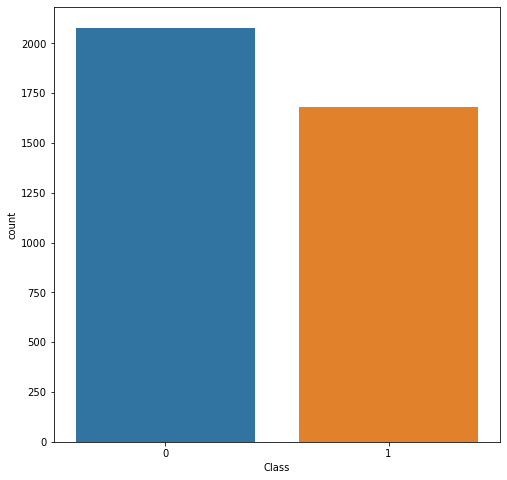

In [28]:
# Identificando o balanceamento das duas classes alvos .
plt.figure(figsize =(8, 8))
sns.countplot(x ='Class', data = cortex_df)
plt.show()

## Vemos que as duas classes são relativamente bem balenceadas, de modo que não precisamos tratar esse grau de desbalanceamento.

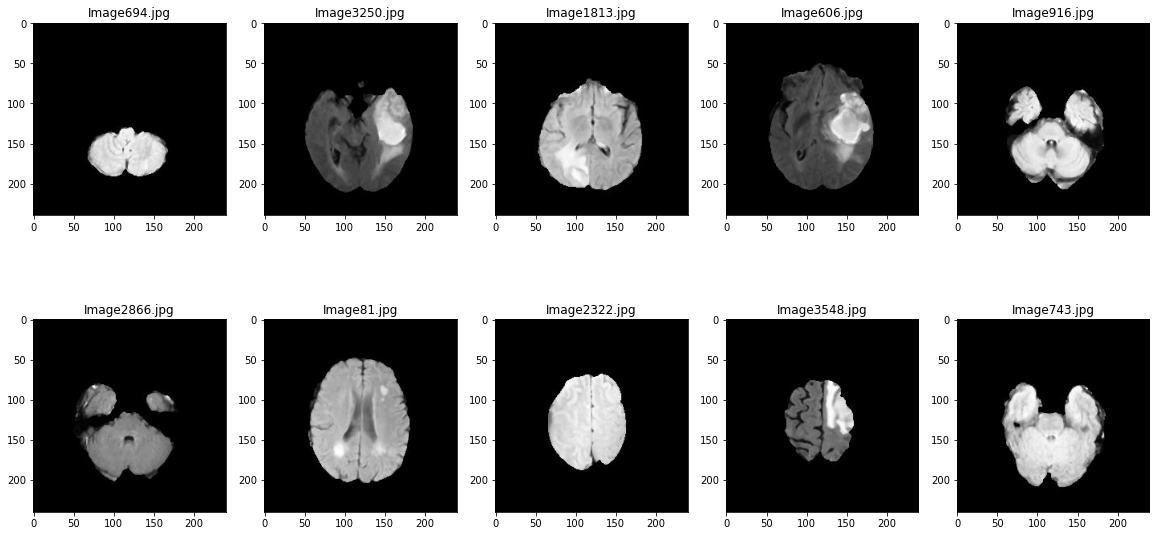

In [32]:
# Exibindo uma amostra de 10 imagens 
plt.figure(figsize=(20,10))
test_folder= "C:\\Users\\rondi\\Documents\\BrainTumorDetection\\Brain_Tumor"
for i in range(10):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(2,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [9]:
# Nesta célula de código associamos cada um dos valores das classes a matriz de pixels das imagens.
dataset_df = pd.DataFrame()
dataset_df["Image"] = cortex_df["Image"]
dataset_df["Class"] = cortex_df["Class"]
path_list = []
for img_path in os.listdir(IMAGE_DATASET):
    path_list.append( os.path.join(IMAGE_DATASET,img_path))
path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in path_list}
dataset_df["paths"] = cortex_df["Image"].map(path_dict.get)
dataset_df["pixels"] = dataset_df["paths"].map(lambda x:np.asarray(open(x).resize((IMG_HEIGHT,IMG_WIDTH))))
dataset_df.head()

,Image,Class,paths,pixels
0,Image1,0,C:\Users\rondi\Documents\BrainTumorDetection\B...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,Image2,0,C:\Users\rondi\Documents\BrainTumorDetection\B...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2,Image3,1,C:\Users\rondi\Documents\BrainTumorDetection\B...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
3,Image4,1,C:\Users\rondi\Documents\BrainTumorDetection\B...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,Image5,0,C:\Users\rondi\Documents\BrainTumorDetection\B...,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


## Separando os dados em features e target.

In [10]:
# Criando uma lista de imagens as featuresm, onde valores das matrizes dos canais RGB normalizados, 
# desse modo teremos os valores no intervlo de 0 e 1. Os valores normalizados são ideias 
# para o CNN lidar.
image_list = []
for i in range(len(dataset_df)):
    brain_image = dataset_df["pixels"][i].astype(np.float32)
    brain_image /= 255
    image_list.append(brain_image)
X = np.array(image_list)
print(X.shape)

(3762, 224, 224, 3)


In [11]:
# Criando targent
y = np.array(dataset_df.Class)
y.shape

(3762,)

In [12]:
# Separando as features e target em partes treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('The shape of the X_train :'+' '+str(X_train.shape))
print('The size of the X_train :'+' '+str(X_train.shape[0]))
print('The shape of the X_test :'+' '+str(X_test.shape))
print('The size of the X_test:'+' '+str(X_test.shape[0]))

The shape of the X_train : (3009, 224, 224, 3)
The size of the X_train : 3009
The shape of the X_test : (753, 224, 224, 3)
The size of the X_test: 753


## Implementando as camadas da rede neural convolucional 

In [13]:
# Para construirmos as camadas das rede neural precisamos definir os parâmetros das camadas convolucionais. 
# kernel_size=3 significa que estamos usando 3 canais de filtro. strides=(2, 2) indica que camada de convolução 
# se desloca de 2 em 2 pixels. O padding='same' indica que as camadas resultantes tem a mesma dimensão. A função 
# de ativação é 'relu', sendo essa melhor tipo de ativação para esse rede.

def model(input_shape):
   
    model = Sequential()
    
    model.add(Input(shape=input_shape))
    
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
            
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation="relu", kernel_initializer="he_normal"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last", padding='same'))
    

    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))   
    
    return model

In [14]:
# Inserindo as dimensões dos dados no modelo
model = model(input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          1

In [16]:
# Utilizamos como otimizador o SGD (Stochastic gradient descent).
optimizer = SGD(learning_rate=0.01)
loss_fn = BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [17]:
# Agora podemos treinar o modelo
history = model.fit(x=X_train, y=y_train, epochs=EPOCHS, batch_size=10)

Epoch 1/50
301/301 [==============================] - 23s 65ms/step - loss: 0.6843 - accuracy: 0.5215
Epoch 2/50
301/301 [==============================] - 18s 61ms/step - loss: 0.5250 - accuracy: 0.7590
Epoch 3/50
301/301 [==============================] - 19s 64ms/step - loss: 0.4627 - accuracy: 0.7995
Epoch 4/50
301/301 [==============================] - 20s 67ms/step - loss: 0.4479 - accuracy: 0.7956
Epoch 5/50
301/301 [==============================] - 22s 73ms/step - loss: 0.4049 - accuracy: 0.8167
Epoch 6/50
301/301 [==============================] - 21s 69ms/step - loss: 0.3575 - accuracy: 0.8459
Epoch 7/50
301/301 [==============================] - 17s 57ms/step - loss: 0.3307 - accuracy: 0.8562
Epoch 8/50
301/301 [==============================] - 18s 59ms/step - loss: 0.2830 - accuracy: 0.8744
Epoch 9/50
301/301 [==============================] - 17s 58ms/step - loss: 0.2565 - accuracy: 0.9006
Epoch 10/50
301/301 [==============================] - 19s 64ms/step - loss: 0.234

In [18]:
# Criamos a função de Loss e Acuracia 
loss = history.history["loss"]
acc = history.history["accuracy"]

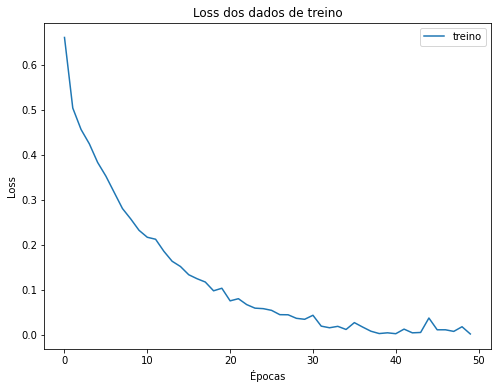

In [47]:
# Plotando a função de Loss em termos das épocas do modelo.
plt.figure(figsize = (8, 6))
epoch = np.arange(EPOCHS)
plt.plot(epoch, loss)
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss dos dados de treino')
plt.legend(['treino', 'val'])
plt.show()

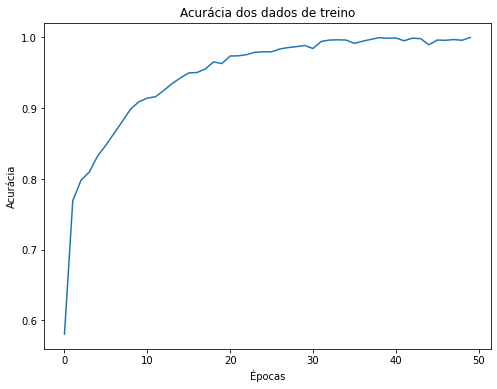

In [45]:
# Plotando a função de acurácia em termos das épocas do modelo.
plt.figure(figsize = (8, 6))
epoch = np.arange(EPOCHS)
plt.plot(epoch, acc)
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Acurácia dos dados de treino');

In [46]:
# Exibindo o valor de loss final e acurácia do modelo
eval_score = model.evaluate(X_test, y_test)
print("Loss dos dados de teste:", eval_score[0])
print("Acurácia dos dados de teste:", "{:.2f}%".format(100*eval_score[1]))

24/24 [==============================] - 3s 35ms/step - loss: 0.1363 - accuracy: 0.9695
Loss dos dados de teste: 0.13625922799110413
Acurácia dos dados de teste: 96.95%


## Nossa rede neural convolucional mostrou uma acurácia de quase 97%. Sendo esse uma valor muito para essa métrica de avaliação do modelo. Esse resultado mostra que a CNN é uma ferra muito podera para classificação de imagens. Ainda podemos adaptar facilemente esse modelo para classificar outros conjuntos de imagens.